# Reactive Greedy Randomized Adaptive Search Procedure for semantic Semi-supervised Trajectory Segmentation (RGRASP-SemTS)  

This is an example of how to use the RGRASP-SemTS algorithm using the hurricanes dataset. 
Please make sure you have all the libraries installed in your python environment.

    tid  sid  latitude  longitude                time  wind          label
0  1374    1      28.4      -67.0 2005-09-05 18:00:00    30  LOW_INTENSITY
1  1374    1      28.4      -66.6 2005-09-06 00:00:00    35  LOW_INTENSITY
               tid          sid     latitude    longitude         wind
count  1990.000000  1990.000000  1990.000000  1990.000000  1990.000000
mean   1425.443216     2.272362    25.909095   -60.124824    56.592965
std      30.724968     1.438950    11.078997    20.940384    26.100227
min    1374.000000     1.000000     8.300000   -99.500000    15.000000
25%    1397.000000     1.000000    17.500000   -77.500000    35.000000
50%    1424.000000     2.000000    23.000000   -61.000000    50.000000
75%    1450.000000     3.000000    32.300000   -45.625000    70.000000
max    1475.000000     9.000000    65.600000    -1.000000   160.000000
Unique trajectory ids [1374 1375 1376 1377 1378 1381 1382 1384 1387 1394 1395 1396 1397 1398
 1399 1402 1404 1406 1409 1410 1412 1415 14

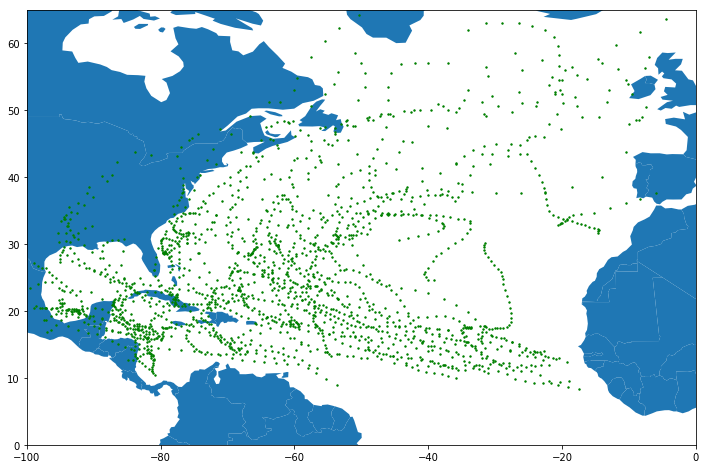

In [1]:
import pandas
import random
import numpy as np
import algorithm.RGRASPSemTS as rgrasp
import algorithm.Evaluate as eval_rg
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib


# read files as a dataframes
dframe = pandas.read_csv('./datasets/hurricanes/hurricanes.csv', header=0, delimiter=',', parse_dates=['time'])
print(dframe.head(2))
print(dframe.describe())

# convert time column to string in format YYYY-MM-DD hh:mm:ss
dframe['time'] = dframe['time'].astype(str)

# check the number of trajectories
print('Unique trajectory ids', dframe["tid"].unique())

# visualizing the dataset on a map
geometry = [Point(xy) for xy in zip(dframe['longitude'], dframe['latitude'])]
gdf = GeoDataFrame(dframe, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(12, 8)), marker='o', markersize=2, color='green')
ax.set_xlim([-100.,0.])
ax.set_ylim([0.,65.])

plt.show()

# Scaling the data for RGRASP-SemTS works with distance similarity functions. 
To avoid that a trajectory feature has a higher importance than others, it is important to scale your data. 
In this example, the MinMaxScaler from the sklearn package is used.

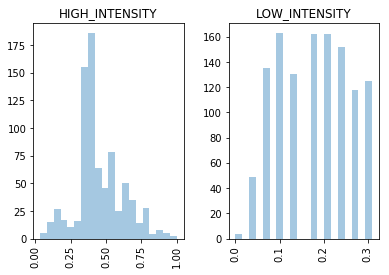

In [2]:
# scaling the trajectory point features data from 0. to 1 with MinMaxScaler
scaler = MinMaxScaler()
# dframe[['direction_inference','speed_inference_m_s','distance_inference_m']] = scaler.fit_transform(dframe[['direction_inference','speed_inference_m_s','distance_inference_m']].to_numpy())
dframe[['wind']] = scaler.fit_transform(dframe[['wind']].to_numpy())

# checking the distribution of the point features by class
dframe_to_plot = dframe[['wind','label']]
dframe_to_plot.hist(bins=20, alpha=0.4, by='label')
plt.show()



# RGRASP-SemTS input data and parameters setup
## Input data
Please make sure that your data is the proper format: 
1. The unlabeled dataset: (tid, latitude, longitude, time, traj_feat1,..., traj_feat_N)
2. The labeled dataset: (tid, latitude, longitude, time, traj_feat1,..., traj_feat_N, class_label)

In [3]:
print(dframe.head(2))
# store geometry for future plot
geom = dframe['geometry']
dframe = dframe.drop(['geometry'], axis=1)
# splitting the data 
# Let's select some examples to be used as a trajectory dataset to be segmented
list_of_tids_to_segment = [1374,1375,1376,1377,1378,1381,1382,1384,1387,1394,1395,1396,1397,1398,1399,1402,1404,1406,1409,1410,1412,1415,1417,1420,1421,1422,1424,1425,1428,1429,1431,1435,1438,1439]
# list_of_tids_to_segment = [1374]
list_of_tids_for_labels = [1442,1443,1447,1448,1449,1450,1453,1454,1455,1456,1457,1466,1468,1471,1472,1473,1474,1475]
# Select the trajectory data as a numpy array, and remove the labeled column
# This column will be forecasted by the RGRASP-SemTS algorithm
y_truth_sid = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)]['sid'].to_numpy()
dframe = dframe.drop(["sid"], axis=1)
trajectory_data = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)].to_numpy()[:,0:-1]
# store the true values of y for evaluating the algorithm further
y_truth_cls = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)].to_numpy()[:,-1]


# Select the labeled dataset as a numpy array
labeled_dataset = dframe.loc[dframe['tid'].isin(list_of_tids_for_labels)].to_numpy()

# print some lines of the selected data
print(trajectory_data[:2])
print(labeled_dataset[:2])


    tid  sid  latitude  longitude                 time      wind  \
0  1374    1      28.4      -67.0  2005-09-05 18:00:00  0.103448   
1  1374    1      28.4      -66.6  2005-09-06 00:00:00  0.137931   

           label                    geometry  
0  LOW_INTENSITY  POINT (-67.00000 28.40000)  
1  LOW_INTENSITY  POINT (-66.60000 28.40000)  
[[1374 28.4 -67.0 '2005-09-05 18:00:00' 0.10344827586206896]
 [1374 28.4 -66.6 '2005-09-06 00:00:00' 0.13793103448275862]]
[[1442 10.7 -31.1 '2010-08-21 12:00:00' 0.06896551724137932
  'LOW_INTENSITY']
 [1442 11.0 -31.7 '2010-08-21 18:00:00' 0.06896551724137932
  'LOW_INTENSITY']]


# Running RGRASP-SemTS 
## Parameters setup
1. max_value: is a the maximal distance between two trajectory points. If not available, you may want to use the square root of the number of trajectory features.
2. seed: An integer seed for reproducing the results of your experiments.
3. reactive_proportion: a value between 0-1 to update the alpha and min_time lists prob. of selection
4. max_iterations: The maximal number of iterations to run the GRASP strategy.
5. lists_size: The number of elements for the alpha and min_time lists.
6. min_time_bounds: The boundaries of the minimal mintime value and maximal mintime value for creating a segment.

## The output of the method
The outcome of RGRASP-SemTS is the total cost of the solutions given to each segmented trajectory (cost), y_pred_sid as an array with all the segment ids of each trajectory point following the same order of the trajectory_data multidimensional array, and y_pred_cls as an array with the class for each trajectory point following the same order of the trajectory_data multidimensional array. 

In [4]:
# RGRASPSem-TS input parameters
max_value = math.sqrt(1.)
seed = 1415
reactive_proportion = .1
max_iterations = 50
lists_size = 10
# min time min and max bounds in seconds (6hours, 18 hours)
min_time_bounds=[6*60*60,18*60*60]

cost, y_pred_sid, y_pred_cls = rgrasp.execute(seed, trajectory_data, labeled_dataset, reactive_proportion, lists_size, max_iterations, max_value, min_time_bounds)

print(cost, y_pred_sid, y_pred_cls)


54.648995983494544 [ 1  1  1 ... 63 63 63] ['HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'HIGH_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LOW_INTENSITY', 'LO

## Evaluating the results
You may want to evaluate the RGRASP-SemTS results using supervised measures such as accuracy, or unsupervised such as segment purity and coverage. For full reference of segment purity and coverage, please check the GRASP-UTS paper in the following link https://www.tandfonline.com/doi/abs/10.1080/13658816.2014.938078 , or the author's version available at https://www.researchgate.net/publication/268217728_GRASP-UTS_an_algorithm_for_unsupervised_trajectory_segmentation

In [5]:
# A point by point accuracy
matches = np.sum(y_truth_cls == y_pred_cls)
print('The number of points that the classes matched is '+str(matches)+' from a total of '+str(len(y_truth_cls)))
print('Percentage is '+str(matches/float(len(y_truth_cls))))
purity = eval_rg.segment_purity(y_truth_cls, y_pred_sid)
coverage = eval_rg.segment_coverage(y_truth_sid, y_pred_sid)
print('The average purity is '+str(purity[1]))
print('The average coverage is '+str(coverage[1]))

The number of points that the classes matched is 793 from a total of 1248
Percentage is 0.6354166666666666
The average purity is 0.8500816449720673
The average coverage is 0.47444999710162467


/Users/asj/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/asj/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


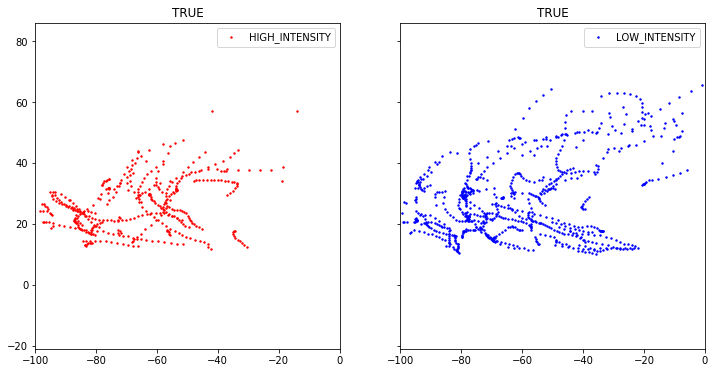

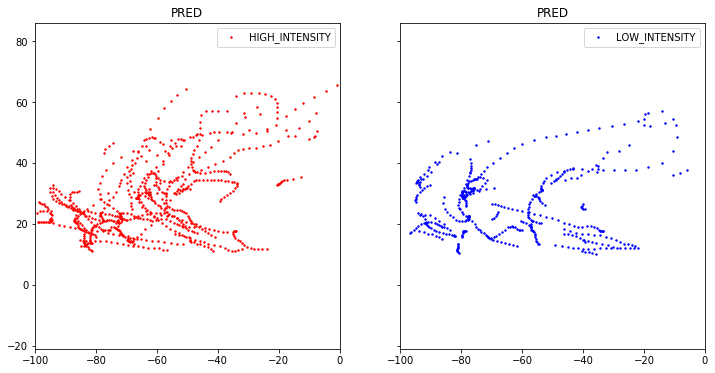

In [6]:
# Plot true values
true_hi_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)][dframe['label'] == 'HIGH_INTENSITY']
# print(true_hi_df.head(3))
true_li_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)][dframe['label'] == 'LOW_INTENSITY']
# print(true_not_fishing_df.head(3))

fig, axes = plt.subplots(1, 2,figsize=(12,6), sharex=True, sharey=True)

# creating geometry columns
geometry = [Point(xy) for xy in zip(true_hi_df['longitude'], true_hi_df['latitude'])]
gdf_fishing = GeoDataFrame(true_hi_df, geometry=geometry)
geometry = [Point(xy) for xy in zip(true_li_df['longitude'], true_li_df['latitude'])]
gdf_not_fishing = GeoDataFrame(true_li_df, geometry=geometry)
ax = gdf_fishing.plot(ax=axes[0], marker='o', markersize=2, color='red', label='HIGH_INTENSITY')
ax.legend(loc="upper right")
ax.set_title('TRUE')
ax.set_xlim([-100.,0.])
ax.set_ylim([0.,65.])
ax = gdf_not_fishing.plot(ax=axes[1], marker='o', markersize=2, color='blue', label='LOW_INTENSITY')
ax.legend(loc="upper right")
ax.set_title('TRUE')
ax.set_xlim([-100.,0.])
ax.set_ylim([0.,65.])

plt.show()

# Plot the forecasted values
pred_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)]
pred_df = pandas.concat([pred_df, pandas.DataFrame({'p_label': y_pred_cls})], axis=1)
# print(pred_df.head(3))

pred_hi_df = pred_df[pred_df['p_label'] == 'HIGH_INTENSITY']
# print(pred_fishing_df.head(3))
pred_li_df = pred_df[pred_df['p_label'] == 'LOW_INTENSITY']
# print(pred_not_fishing_df.head(3))

fig, axes = plt.subplots(1, 2, figsize=(12,6),sharex=True, sharey=True)

# creating geometry columns
geometry = [Point(xy) for xy in zip(pred_hi_df['longitude'], pred_hi_df['latitude'])]
gdf_fishing = GeoDataFrame(pred_hi_df, geometry=geometry)
geometry = [Point(xy) for xy in zip(pred_li_df['longitude'], pred_li_df['latitude'])]
gdf_not_fishing = GeoDataFrame(pred_li_df, geometry=geometry)
ax = gdf_fishing.plot(ax=axes[0], marker='o', markersize=2, color='red', label='HIGH_INTENSITY')
ax.legend(loc="upper right")
ax.set_title('PRED')
ax.set_xlim([-100.,0.])
ax.set_ylim([0.,65.])
ax = gdf_not_fishing.plot(ax=axes[1], marker='o', markersize=2, color='blue', label='LOW_INTENSITY')
ax.legend(loc="upper right")
ax.set_title('PRED')
ax.set_xlim([-100.,0.])
ax.set_ylim([0.,65.])
plt.show()